<a href="https://colab.research.google.com/github/KimRass/Programming/blob/master/Data%20Science/Machine%20Learning/Computer%20Vision/Selective%20Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data Science/Machine Learning/Computer Vision/Selective Search.ipynb

from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/Libraries")

import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import selectivesearch
import cv2
import numpy as np

plt.style.use("dark_background")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


img shape: (450, 375, 3)


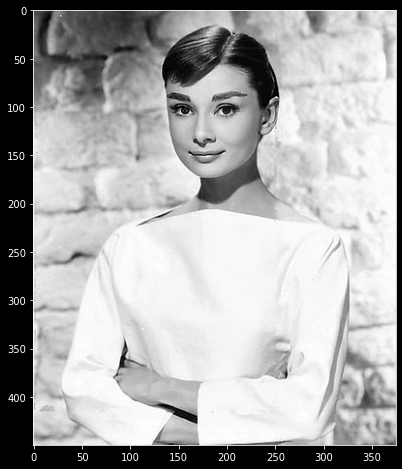

In [ ]:
os.chdir("/content/drive/MyDrive/CV")

img = cv2.imread("Audrey Hepburn.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("img shape:", img.shape)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.show()

In [ ]:
_, regions = selectivesearch.selective_search(img_rgb, scale=100, min_size=2000)

print(type(regions), len(regions))

<class 'list'> 41


In [ ]:
regions[0]

{'labels': [0.0], 'rect': (0, 0, 107, 167), 'size': 11166}

In [ ]:
cand_rects = [cand["rect"] for cand in regions]
# (left_top_x, left_top_y, width, height)
print(cand_rects)

[(0, 0, 107, 167), (15, 0, 129, 110), (121, 0, 253, 133), (134, 17, 73, 62), (166, 23, 87, 176), (136, 53, 88, 121), (232, 79, 117, 147), (50, 91, 133, 123), (305, 97, 69, 283), (0, 161, 70, 46), (72, 171, 252, 222), (0, 181, 118, 85), (106, 210, 89, 101), (302, 228, 66, 96), (0, 253, 92, 134), (153, 270, 173, 179), (0, 305, 47, 139), (104, 312, 80, 71), (84, 360, 91, 67), (0, 362, 171, 87), (297, 364, 77, 85), (0, 91, 183, 175), (136, 23, 117, 176), (72, 171, 254, 278), (134, 17, 119, 182), (302, 97, 72, 283), (121, 0, 253, 226), (0, 91, 183, 175), (0, 0, 144, 167), (0, 0, 253, 199), (0, 253, 92, 191), (0, 91, 183, 353), (0, 171, 326, 278), (0, 97, 374, 352), (84, 312, 100, 115), (0, 91, 184, 353), (0, 91, 195, 353), (0, 0, 374, 444), (0, 0, 374, 449), (0, 0, 374, 449), (0, 0, 374, 449)]


draw bounding box

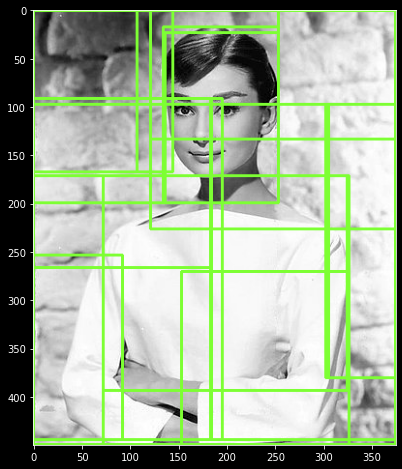

In [ ]:
# cand_rects = [cand["rect"] for cand in regions if cand["size"] > 10000]

green_rgb = (125, 255, 51)
for rect in cand_rects:   
    img_recs = cv2.rectangle(img=img_rgb_copy, pt1=(rect[0], rect[1]),
                                 pt2=(rect[0]+rect[2], rect[1]+rect[3]),
                                 color=green_rgb, thickness=2)
    
plt.figure(figsize=(8, 8))
plt.imshow(img_recs)
plt.show()

IOU

In [ ]:
def compute_iou(cand_box, gt_box):
    # Calculate intersection areas
    x1 = np.maximum(cand_box[0], gt_box[0])
    y1 = np.maximum(cand_box[1], gt_box[1])
    x2 = np.minimum(cand_box[2], gt_box[2])
    y2 = np.minimum(cand_box[3], gt_box[3])
    
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    
    cand_box_area = (cand_box[2] - cand_box[0]) * (cand_box[3] - cand_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union = cand_box_area + gt_box_area - intersection
    
    iou = intersection / union
    return iou

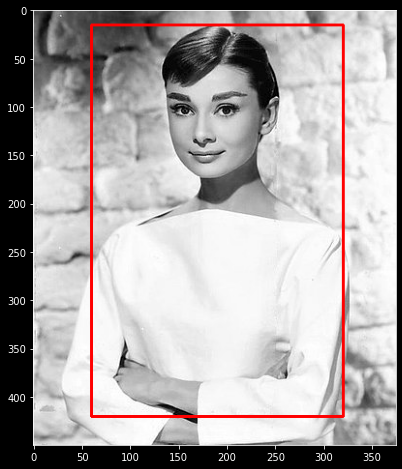

In [ ]:
# Ground Truth
gt_box = [60, 15, 320, 420]

red = (255, 0 , 0)
img_gt = cv2.rectangle(img=img_rgb, pt1=(gt_box[0], gt_box[1]), pt2=(gt_box[2], gt_box[3]), color=red, thickness=2)

plt.figure(figsize=(8, 8))
plt.imshow(img_gt)

In [ ]:
_, regions = selectivesearch.selective_search(img_rgb, scale=100, min_size=2000)

print(type(regions), len(regions))

<class 'list'> 53


In [ ]:

cand_rects = [cand["rect"] for cand in regions]
for index, cand_box in enumerate(cand_rects):
    cand_box = list(cand_box)
    cand_box[2] += cand_box[0]
    cand_box[3] += cand_box[1]
    
    iou = compute_iou(cand_box, gt_box)
    print("index:", index, "iou:", iou)

index: 0 iou: 0.0
index: 1 iou: 0.0713319505816575
index: 2 iou: 0.1134453781512605
index: 3 iou: 0.9874899187876287
index: 4 iou: 0.9748907882241216
index: 5 iou: 0.09851851851851852
index: 6 iou: 0.04228869895536562
index: 7 iou: 0.15042735042735042
index: 8 iou: 0.14541310541310543
index: 9 iou: 0.10112060778727446
index: 10 iou: 0.1194681861348528
index: 11 iou: 0.14017094017094017
index: 12 iou: 0.0
index: 13 iou: 0.0
index: 14 iou: 0.5933903133903133
index: 15 iou: 0.0
index: 16 iou: 0.0853656220322887
index: 17 iou: 0.12535612535612536
index: 18 iou: 0.0
index: 19 iou: 0.1498762283399595
index: 20 iou: 0.0
index: 21 iou: 0.05242165242165242
index: 22 iou: 0.0
index: 23 iou: 0.050123456790123457
index: 24 iou: 0.07313390313390314
index: 25 iou: 0.009348810110697799
index: 26 iou: 0.0
index: 27 iou: 0.23817663817663817
index: 28 iou: 0.18719489628676664
index: 29 iou: 0.19555555555555557
index: 30 iou: 0.20454890788224123
index: 31 iou: 0.0
index: 32 iou: 0.5958024691358025
index:

In [ ]:
cand_rects = [cand["rect"] for cand in regions if cand["size"] > 5000]
cand_rects.sort()
cand_rects

[(0, 0, 58, 257),
 (0, 0, 58, 266),
 (0, 0, 58, 266),
 (0, 0, 171, 449),
 (0, 0, 195, 449),
 (0, 0, 374, 449),
 (0, 0, 374, 449),
 (0, 0, 374, 449),
 (0, 256, 57, 188),
 (0, 256, 171, 193),
 (16, 0, 270, 50),
 (16, 0, 270, 109),
 (16, 0, 270, 199),
 (16, 0, 302, 418),
 (62, 17, 256, 401),
 (63, 0, 311, 449),
 (63, 18, 114, 91),
 (63, 91, 120, 123),
 (63, 91, 132, 220),
 (63, 171, 254, 246),
 (63, 171, 254, 247),
 (63, 171, 254, 247),
 (63, 171, 311, 278),
 (84, 313, 290, 136),
 (84, 360, 290, 89),
 (84, 360, 290, 89),
 (134, 18, 119, 181),
 (136, 23, 117, 176),
 (153, 366, 151, 51),
 (166, 23, 87, 176),
 (197, 0, 177, 420),
 (197, 18, 120, 132),
 (197, 18, 120, 209),
 (232, 79, 85, 148),
 (284, 0, 90, 420),
 (284, 0, 90, 420),
 (284, 0, 90, 420),
 (323, 105, 51, 248)]

index: 5 iou: 0.6270619201314865 rectangle: (0, 0, 374, 449)
index: 6 iou: 0.6270619201314865 rectangle: (0, 0, 374, 449)
index: 7 iou: 0.6270619201314865 rectangle: (0, 0, 374, 449)
index: 13 iou: 0.815085997397344 rectangle: (16, 0, 318, 418)
index: 14 iou: 0.9748907882241216 rectangle: (62, 17, 318, 418)
index: 15 iou: 0.7389566501483806 rectangle: (63, 0, 374, 449)
index: 19 iou: 0.5933903133903133 rectangle: (63, 171, 317, 417)
index: 20 iou: 0.5958024691358025 rectangle: (63, 171, 317, 418)
index: 21 iou: 0.5958024691358025 rectangle: (63, 171, 317, 418)
index: 22 iou: 0.5008648690956052 rectangle: (63, 171, 374, 449)


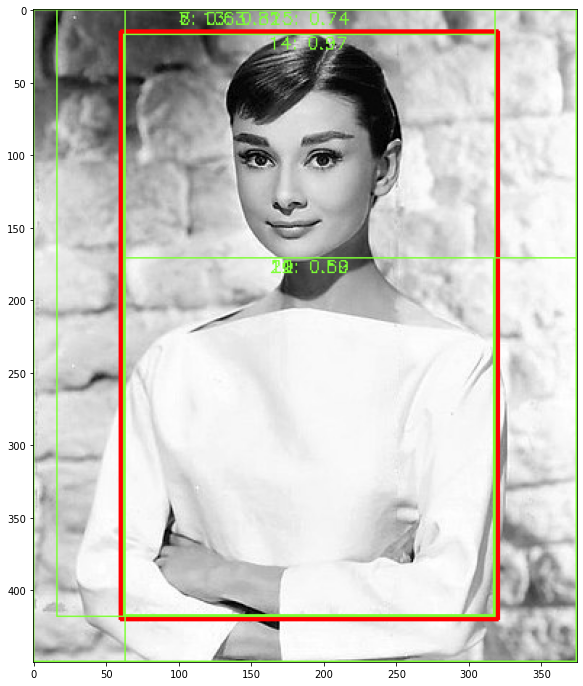

In [ ]:
# img = cv2.imread("audrey01.jpg")
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print("img shape:", img.shape)

# green_rgb = (125, 255, 51)
# cand_rects = [cand["rect"] for cand in regions if cand["size"] > 3000]
# gt_box = [60, 15, 320, 420]
# img_rgb = cv2.rectangle(img_rgb, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), color=red, thickness=2)

for index, cand_box in enumerate(cand_rects):
    
    cand_box = list(cand_box)
    cand_box[2] += cand_box[0]
    cand_box[3] += cand_box[1]
    
    iou = compute_iou(cand_box, gt_box)
    
    if iou > 0.5:
        print("index:", index, "iou:", iou, "rectangle:",(cand_box[0], cand_box[1], cand_box[2], cand_box[3]) )
        cv2.rectangle(img_rgb, (cand_box[0], cand_box[1]), (cand_box[2], cand_box[3]), color=green_rgb, thickness=1)
        text = "{}: {:.2f}".format(index, iou)
        cv2.putText(img_rgb, text, (cand_box[0]+ 100, cand_box[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color=green_rgb, thickness=1)
    
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.show()